# Drawing from Conditional Density

For our utility loss estimate, we need to draw from the joint prior distribution conditioned on one's own valuation. The utility loss is defined as

$$L_\text{utility}(b) \; = \; \max_{v_i \in \mathcal{V_i}} \, \max_{b_i^* \in \mathcal{A_i}} \, E_{v_{-i}|v_i}\left[u(v_i,b_i^*,b_{-i}(v_{-i}))-u(v_i,b_i,b_{-i}(v_{-i}))\right],$$

where we take the maximum utility increase over all possible actions (on a grid) and take the maximum over all our valuations. This expectation has to be drawn over $(v_{-i}|v_i)$.

The current implementation assumes independence of the $v_i$'s and just samples each component individually, causing a systemnatic bias when there are dependencies.

In [2]:
# imports
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from sklearn.neighbors import KernelDensity
from scipy import integrate
import torch
from scipy.special import lambertw

# 1. Analytic solution in Mineral Rights case
### Sample from original distribution
__Krishna__: Suppose that there are three bidders with a common value $V$ for the object that is uniformly distributed on $[0,1]$. Given $V =v$, bidders' signals $X_i$ are uniformly and independently distributed on $[0,2v]$.

*Warning*: Notice the difference between agents' signals (what they can base their action on) and their valuation (unoberservable a priori, which is used to calculate the realized utility).

In [3]:
# mineral rights distribution
n_samples = 5000
sig = np.random.uniform(0, 1, n_samples)
data = np.array([np.random.uniform(0, 2*sig, n_samples),
                 np.random.uniform(0, 2*sig, n_samples)]).T

### Plot originial joint distribution samples

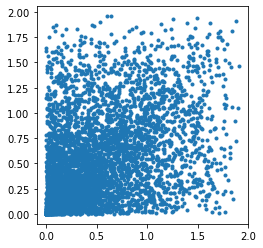

In [4]:
# plot originial and estimated distribution samples
ax = plt.gca()
plt.plot(data[:,0], data[:,1], '.')
ax.set_aspect('equal', 'box')
plt.show()

The mineral rights analytic joint density is given as $$f(x_1, x_2, x_3) = \frac{4 - z^2}{16z^2},$$
where $z = \max\{x_1,x_2,x_3\}$.

In [5]:
def density(x):
    """
    Mineral rights analytic density.
    
    Given in Krishna.
    """
    x = x.view(-1, 3)
    zz = torch.max(x, axis=1)[0]
    result = (4 - zz**2) / (16 * zz**2)
    result[torch.any(x < 0, 1)] = 0
    result[torch.any(x > 2, 1)] = 0
    return result

def marginal_pdf(x):
    """
    Marginal density. Calulated via product density of two uniform
    distributions.
    """
    return -torch.log(x/2) / 2

#### Check if PDFs integrate to one

In [6]:
def mc_integrate(pdf, dim, n=int(1e6)):
    samples = np.random.uniform(0, 2, (n, dim))
    return torch.mean(pdf(torch.tensor(samples))).item() * (2 ** dim)

print('volume of $f(x_1,x_2,x_3)$:', mc_integrate(density, 3))
print('volume of $f(x_1)$:        ', mc_integrate(marginal_pdf, 1))

volume of $f(x_1,x_2,x_3)$: 0.9854584648602821
volume of $f(x_1)$:         1.000092466827081


# Light weight approach
Denote by $v$ the common type and $o_i = v \cdot u_i$ agent $i$'s observation with her unobserved private signal $u_i$.

Firstly, we have $$o_2|o_1 = v|o_1 \cdot u_2|o_1,$$ where $u_2|o_1$ is cond. independent of $o_1$ (can be sampled uniformly). Therefore, we only need to sample $v|o_1$ once and $o_2$, $o_3$ independent from uniform distributions.

In [107]:
# Distribution of type $V$ given the signals $X$:
# in this case $v_i|o_i$ is the same as $v_i|(o_1,o_2,o_3)$
def pdf_v_cond_x(z):
    def pdf(v):
        results = (1/(8 * v**3)) * ((16 * z**2)/(4 - z**2))
        mask = torch.logical_or(v <= 0.5 * z, v >= 1)
        results[mask] = 0
        return results
    return pdf

def cdf_v_cond_x(z):
    c = -4 / (z**2 - 4)
    def cdf(v):
        results = (z**2) / (v**2 * (-4 + z**2)) + c
        results[v <= 0.5 * z] = 0      
        results[v >= 1] = 1
        return results
    return cdf

def icdf_v_cond_x(z):
    c = -4 / (z**2 - 4)
    def icdf(v):
        return z / torch.sqrt(-c * z**2 + 4*c + v*z**2 - 4*v)
    return icdf

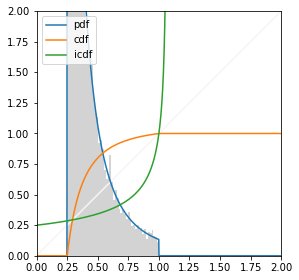

volume: 1.0054116547107697


In [109]:
cond = torch.tensor(.5)

v = torch.linspace(0, 2, 1000)
p = pdf_v_cond_x(cond)(v).squeeze()
c = cdf_v_cond_x(cond)(v).squeeze()
i = icdf_v_cond_x(cond)(x).squeeze()

fig = plt.figure(figsize=(16/2, 9/2))
ax = plt.gca()
plt.plot(x, x, color='whitesmoke')
plt.plot(v, p, label='pdf')
plt.plot(v, c, label='cdf')
plt.plot(x, i, label='icdf')
plt.hist(icdf_v_cond_x(cond)(torch.tensor(np.random.uniform(0, 1, len(x)))),
         50, color='lightgrey', density=True)
plt.xlim([0, 2]); plt.ylim([0, 2])
plt.legend(loc='upper left')
ax.set_aspect('equal', 'box')
plt.show()
print('volume:', torch.mean(pdf_v_cond_x(cond)(v[torch.logical_and(v > cond.item()/2, v < 1)])).item()
      * (1 - cond.item()/2))

---

# Deprecated: Ancestral Sampling

To calulate the best response of agent $i=1$, we need to sample from $f(x_2, x_3| x_1)$. As we can only get uniform pseudorandom numbers in `Pytorch` (and some other common random values), we can follow the following **Ancestral Sampling** approach (see e.g. https://www.cs.ubc.ca/~schmidtm/Courses/540-W18/L20.pdf): Given $x_1$,
1. Sample from $f(x_2|x_1)$ by using $u_0 \sim U(0,1)$ and set $x_2^{sample} = \text{icdf}_{x_2|x_1}(u_0)$
2. Sample from $f(x_3|x_1, x_2)$ by using $u_1 \sim U(0,1)$ and set $x_3^{sample} = \text{icdf}_{x_3|x_1, x_2}(u_1)$

Then $(x_2^{sample}, x_3^{sample}) \sim f(x_2, x_3| x_1)$.

### Marginal distribution $f(x_1)$

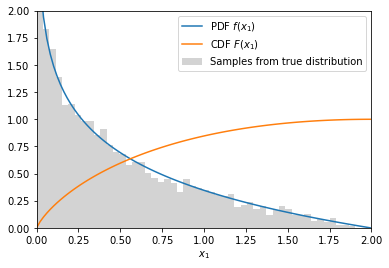

volume: 1.031786322593689


In [7]:
x = torch.linspace(1e-3, 2, 100)
plt.hist(data[:, 0], 50, color='lightgrey', density=True,
         label='Samples from true distribution')
plt.plot(x, marginal_pdf(x), label='PDF $f(x_1)$')
plt.plot(x, 0.5 * (x - x*np.log(x/2)), label='CDF $F(x_1)$')
plt.xlim([0, 2]), plt.ylim([0, 2]); plt.xlabel('$x_1$')
plt.legend(loc='upper right')
plt.show()
print('volume:', 2*torch.mean(marginal_pdf(x)).item())

### Calculate PDFs ans CDFs when conditioning on two of three agents

This falls down according to $f(x_1|x_2,x_3)=f(x_1|max\{x_2,x_3\})$

In [8]:
# 2. Step in Ancestral Sampling
def cond2_pdf(cond1, cond2):
    """PDF when conditioning on two of three agents"""
    z = torch.max(cond1, cond2)
    factor = (4*z) / (2 - z) # s.t. it integrates to 1
    def pdf(x):
        x = x.view(-1, 1)
        return factor * density(torch.cat([cond1 * torch.ones_like(x), cond2 * torch.ones_like(x), x], 1))
    return pdf

# 2.a
def cond2_cdf(cond1, cond2):
    """CDF when conditioning on two of three agents"""
    z = torch.max(cond1, cond2)
    factor_1 = (4*z) / (2 - z)
    factor_2 = (4-z**2) / (16*z**2)
    def cdf(x):
        result = np.zeros_like(x)
        f1 = factor_1 * torch.ones_like(x)
        f2 = factor_2 * torch.ones_like(x)
        zz = z * np.ones_like(x)

        result[x < z] = f1[x < z] * f2[x < z] * x[x < z]
        result[x >= z] = f1[x >= z] * (f2[x >= z] * zz[x >= z] - (x[x >= z]**2 + 4)/(16*x[x >= z]) \
            + (zz[x >= z]**2 + 4)/(16*zz[x >= z]))
        result[x < 0] = 0 # use clipping
        result[x >= 2] = 1
        return result
    return cdf

# 2.b
def cond2_icdf(cond1, cond2):
    """iCDF when conditioning on two of three agents"""
    z = torch.max(cond1, cond2).squeeze()
    factor_1 = (4*z) / (2 - z)
    factor_2 = (4 - z**2) / (16*z**2)
    def icdf(x):
        result = torch.zeros_like(x)
        f1 = factor_1 * torch.ones_like(x)
        f2 = factor_2 * torch.ones_like(x)
        zz = z * torch.ones_like(x)
        sect1 = x < zz * f1 * f2
        result[sect1] = x[sect1] / f1[sect1] / f2[sect1]

        sect2 = torch.logical_not(sect1)
        f1 = f1[sect2]
        f2 = f2[sect2]
        zz = zz[sect2]
        result[sect2] = -(torch.sqrt(-32*f1*x[sect2]*zz*(16*f2*zz**2 + zz**2 + 4) + f1**2*(256*f2**2*zz**4 \
            + 32*f2*(zz**2 + 4)*zz**2 + (zz**2 - 4)**2) + 256*x[sect2]**2*zz**2) - f1*(16*f2*zz**2 + zz**2 \
            + 4) + 16*x[sect2]*zz) / (2*f1*zz)

        return result
    return icdf

### Plot PDF and CDF of $f(x_1|x_2,x_3)$

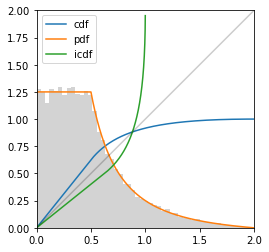

volume: 1.0000624656677246


In [9]:
x = torch.arange(0, 2, .0001)
cond = .5

ax = plt.gca()
plt.plot(x, cond2_cdf(torch.tensor(cond), torch.tensor(0.))(x).squeeze(), label='cdf')
plt.plot(x, cond2_pdf(torch.tensor(cond), torch.tensor(0.))(x).squeeze(), label='pdf')
plt.plot(x[x < 1], cond2_icdf(torch.tensor(cond), torch.tensor(0.))(x[x < 1]).squeeze(), label='icdf')
plt.plot(x, x, color='black', alpha=.2)
plt.hist(cond2_icdf(torch.tensor(cond), torch.tensor(0.))(torch.tensor(np.random.uniform(0, 1, len(x)))),
         50, color='lightgrey', density=True)
plt.xlim([0, 2]); plt.ylim([0, 2])
plt.legend()
ax.set_aspect('equal', 'box')
plt.show()
print('volume:', 2*torch.mean(cond2_pdf(torch.tensor(cond), torch.tensor(0.))(x)).item())

### Calculate PDFs ans CDFs when conditioning on one agent, marginalizing the other


In [10]:
def lambertw_approx(z, iters=10):
    """
    Approximation of Lambert W function via Halley’s method for
    positive values and via Winitzki approx. for negative values.
    """
    a = torch.zeros_like(z)
    eps = 0
    mask = z > eps

    for i in range(iters):
        a[mask] = a[mask] - (a[mask]*torch.exp(a[mask]) - z[mask]) / \
            (torch.exp(a[mask])*(a[mask] + 1)-((a[mask] + 2)*(a[mask]*torch.exp(a[mask]) - z[mask]))/(2*a[mask]+2))
    
    a[~mask] = (np.exp(1)*z[~mask]) / \
        (1 + ((np.exp(1) - 1)**(-1) - 1/np.sqrt(2) + 1/torch.sqrt(2*np.exp(1)*z[~mask] + 2))**(-1))
    return a

In [11]:
# distribution we want to sample from!
def cond1_pdf(cond):
    """PDF of two given one"""
    factor = 1. / marginal_pdf(cond)
    def pdf(x):
        x = x.view(-1, 2)
        return factor * density(torch.cat([cond * torch.ones((x.shape[0], 1)), x], 1))
    return pdf

# 1. Step in Ancestral Sampling
def cond_marginal_pdf(cond):
    """PDF of one, marginal one and given one"""
    def pdf(x):
        result = torch.zeros_like(x)
        maximum = x.clone()
        maximum[x < cond] = cond
        result = (maximum - 2) / (2*maximum * torch.log(cond/2))
        return result
    return pdf

# 1.a
def cond_marginal_cdf(cond):
    """CDF of one, marginal one and given one"""
    z = cond
    f = (cond - 2) / (2*cond*torch.log(cond/2))
    c_1 = f * z
    c_2 = 2 * torch.log(cond/2)
    c_3 = (cond - 2*torch.log(cond)) / (2*torch.log(cond/2))
    def cdf(x):
        x = x.view(-1, 1)
        result = torch.zeros_like(x)
        result[x < z] = f * x[x < z]
        result[x >= z] = c_1 + (x[x >= z] - 2*torch.log(x[x >= z])) / c_2 - c_3
        result[x < 0] = 0 # use clipping
        result[x >= 2] = 1
        return result
    return cdf

# 1.b
def cond_marginal_icdf(cond):
    """iCDF of one, marginal one and given one"""
    z = cond.view(-1, 1)
    f = (z - 2) / (2*z * torch.log(z/2))
    f_inv = 1. / f
    c_1 = f * z
    c_2 = 2 * torch.log(z/2)
    c_3 = (z - 2*torch.log(z)) / (2*torch.log(z/2))
    def cdf(x):
        xx = x.view(-1, 1).repeat(z.shape[0], 1).view(z.shape[0], x.shape[0])
        zz = z.repeat(1, x.shape[0]).view(z.shape[0], x.shape[0])
        ff = f.repeat(1, x.shape[0]).view(z.shape[0], x.shape[0])
        ff_inv = f_inv.repeat(1, x.shape[0]).view(z.shape[0], x.shape[0])
        cc_1 = c_1.repeat(1, x.shape[0]).view(z.shape[0], x.shape[0])
        cc_2 = c_2.repeat(1, x.shape[0]).view(z.shape[0], x.shape[0])
        cc_3 = c_3.repeat(1, x.shape[0]).view(z.shape[0], x.shape[0])

        result = torch.zeros((z.shape[0], x.shape[0]), device=x.device)
        mask = xx < ff * zz 
        result[mask] = ff_inv[mask] * xx[mask]
        result[~mask] = -2 * lambertw_approx(
            - 1 / (2*torch.sqrt(torch.exp(cc_2[~mask]*(xx[~mask] - cc_1[~mask] + cc_3[~mask]))))
        )
        return result
    return cdf

#def marginal1_pdf(x):
#    """PDF marginal of two"""
#    x = np.atleast_2d(x)
#    result = np.zeros(x.shape[0])
#    maximum = np.max(x, 1)
#    result = density(np.concatenate([np.zeros((x.shape[0], 1)), x], 1)) * maximum \
#        - 0.25 + (maximum**2 + 4)/(16*maximum)
#    return result

#def cond1_icdf(cond):
#    c = (cond**2 + 4) / (16*cond)
#    def icdf(x):
#        result = np.zeros(x.shape[0])
#        maximum = np.max(x, 1)
#        
#        # case 1
#        select1 = x[:, 0] < x[:, 1]
#        result[select1] = cond2_icdf(cond, 0)(x[select1, 0])
#
#        # case 2
#        select2 = np.logical_not(select1)
#        result[select2] = cond2_icdf(cond, 0)(x[select2, 1])
#
#        result[np.any(x < 0, 1)] = 0
#        result[np.any(x > 1, 1)] = 1
#        return result
#    return icdf

### Plot PDF and CDF of marginal distribution conditioned on one $f(x_1|x_2)$

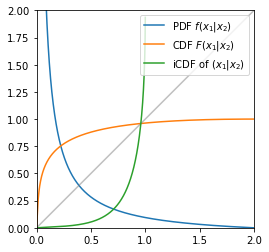

volume: 1.0009404420852661


In [12]:
x = torch.arange(0, 2, .0001)
cond = .01

ax = plt.gca()
plt.plot(x, cond_marginal_pdf(torch.tensor(cond))(x), label='PDF $f(x_1|x_2)$')
plt.plot(x, cond_marginal_cdf(torch.tensor(cond))(x), label='CDF $F(x_1|x_2)$')
plt.plot(x, x, alpha=.5, color='grey')
plt.plot(x[x < 1], cond_marginal_icdf(torch.tensor(cond))(x[x < 1])[0,:], label='iCDF of $(x_1|x_2)$')
plt.legend(loc='upper right')
plt.xlim([0, 2]); plt.ylim([0, 2])
ax.set_aspect('equal', 'box')
plt.show()
print('volume:', 2*torch.mean(cond_marginal_pdf(torch.tensor(cond))(x)).item())

### Plotting of joint distribution of $(x_2, x_3)$ conditioned on $x_1$
This is the multivariate ditribution we want to sample from.

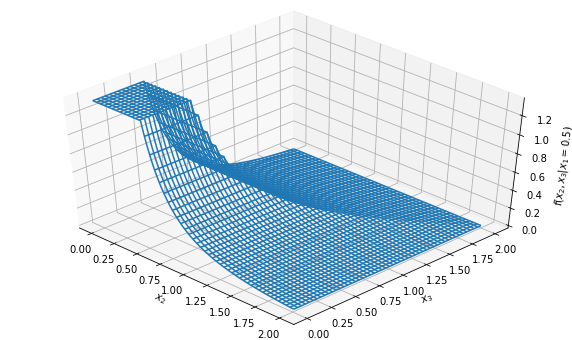

volume: 0.9885310530662537


In [13]:
cond = torch.tensor(.5)
x = np.linspace(1e-2, 2, 1000)
X, Y = np.meshgrid(x, x)

X_flat = np.atleast_2d(X.flatten()).T
Y_flat = np.atleast_2d(Y.flatten()).T
#Z_flat = marginal1_pdf(np.concatenate((X_flat, Y_flat), 1))
Z_flat = cond1_pdf(cond)(torch.cat((torch.tensor(X_flat), torch.tensor(Y_flat)), 1).to(torch.float))
#Z_flat = marginal1_cdf(np.concatenate((X_flat, Y_flat), 1))

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z_flat.reshape(X.shape))
ax.view_init(45, -45)
ax.set_xlabel('$x_2$'); ax.set_ylabel('$x_3$'); ax.set_zlabel('$f(x_2, x_3| x_1={})$'.format(cond))
#ax.set_zlim([0, 10])
plt.show()
print('volume:', torch.mean(Z_flat.reshape(X.shape)).item() * 2 * 2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


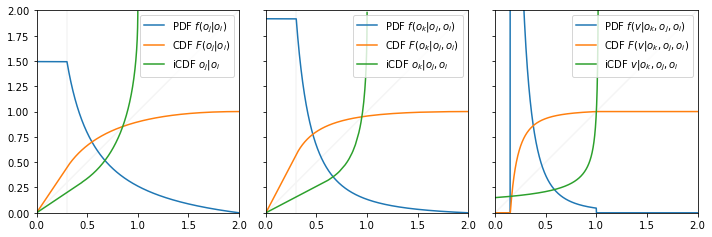

In [23]:
fig, axs = plt.subplots(
    nrows=1, ncols=3, sharex=True,
    sharey=True,
    figsize=(10, 4)
)
x = torch.arange(0, 2, .00001)
cond = 0.3

# cond_marginal_pdf
ax = axs[0]
ax.plot(x, x, color='whitesmoke')
ax.plot([cond, cond], [0, 2], color='whitesmoke')
ax.plot(x, cond_marginal_pdf(torch.tensor(cond))(x), label='PDF $f(o_j|o_i)$')
ax.plot(x, cond_marginal_cdf(torch.tensor(cond))(x), label='CDF $F(o_j|o_i)$')
ax.plot(x[x < 1], cond_marginal_icdf(torch.tensor(cond))(x[x < 1])[0, :], label='iCDF $o_j|o_i$')
#ax.hist(cond_marginal_icdf(torch.tensor(cond))(torch.tensor(np.random.uniform(0, 1, len(x)), dtype=torch.float)),
#         50, color='lightgrey', density=True)
ax.legend(loc='upper right')
ax.set_xlim([0, 2]); ax.set_ylim([0, 2])
ax.set_aspect('equal', 'box')

# cond2_cdf
ax = axs[1]
ax.plot(x, x, color='whitesmoke')
ax.plot([cond, cond], [0, 2], color='whitesmoke')
ax.plot(x, cond2_pdf(torch.tensor(cond), torch.tensor(0.))(x).squeeze(), label='PDF $f(o_k|o_j,o_i)$')
ax.plot(x, cond2_cdf(torch.tensor(cond), torch.tensor(0.))(x).squeeze(), label='CDF $F(o_k|o_j,o_i)$')
ax.plot(x[x < 1], cond2_icdf(torch.tensor(cond), torch.tensor(0.))(x[x < 1]).squeeze(), label='iCDF $o_k|o_j,o_i$')
#plt.hist(cond2_icdf(torch.tensor(cond), torch.tensor(0.))(torch.tensor(np.random.uniform(0, 1, len(x)))),
#         50, color='lightgrey', density=True)
ax.set_xlim([0, 2]); ax.set_ylim([0, 2])
ax.legend(loc='upper right')
ax.set_aspect('equal', 'box')

# cond2_cdf
ax = axs[2]
v = torch.linspace(0, 2, 1000)
p = pdf_v_cond_x(cond)(v).squeeze()
c = cdf_v_cond_x(cond)(v).squeeze()
i = icdf_v_cond_x(cond)(x).squeeze()

# cond type
ax.plot(x, x, color='whitesmoke')
ax.plot(v, p, label='PDF $f(v|o_k,o_j,o_i)$')
ax.plot(v, c, label='CDF $F(v|o_k,o_j,o_i)$')
ax.plot(x, i, label='iCDF $v|o_k,o_j,o_i$')
#ax.hist(icdf_v_cond_x(cond)(torch.tensor(np.random.uniform(0, 1, len(x)))),
#        50, color='lightgrey', density=True)
ax.set_xlim([0, 2]); ax.set_ylim([0, 2])
ax.legend(loc='upper right')
ax.set_aspect('equal', 'box')


plt.tight_layout()
plt.savefig('densities_common.eps', transparent=True, pad_inches=0.0)
plt.show()

In [ ]:
cond = torch.tensor(0.1)
n = int(1e5)
u = torch.zeros(n, 2).uniform_(0, 1)
x0 = cond_marginal_icdf(cond)(u[:, 0]).squeeze()
x1 = cond2_icdf(cond, x0)(u[:, 1])

# Need to clip for numeric problems at edges + use symmetry to decrease bias
x = torch.stack((x0, x1)).t_()
x = torch.clamp(x, 0, 2)
cut = int(n / 2)
temp = x[:cut, 0].clone()
x[:cut, 0] = x[:cut, 1]
x[:cut, 1] = temp
x = x[torch.randperm(x.size()[0]), :]

**TODO:** check out if iCDFs can be adapted s.t. problems with a condition close to zero decrease

In [ ]:
# plot samples
fig = plt.figure()
ax = plt.gca()
plt.plot(x[:, 0], x[:, 1], '.', alpha=.1)
#plt.xlim([0, 2]); plt.ylim([0, 2])
plt.title('Samples from $f(x_2, x_3| x_1)$'); plt.xlabel('$x_2$'); plt.ylabel('$x_3$')
ax.set_aspect('equal', 'box')
plt.show()

---
# Deprecated: General case
Approximation for cases when we're not able to sample from $f(x_{-i}| x_i)$, e.g., when we can't calulate the inverse CDFs.

## 1. Use MCMC

In [ ]:
def mcmc(target, N, x, VCOV, burnin=0):
    """
    MCMC for drwaning samples from `target`
    Source: https://blog.abhranil.net/2014/02/08/r-code-for-multivariate-random-walk-metropolis-hastings-sampling/
    """
    samples = np.array(x).reshape(1, 2)
    for i in range(2, burnin + N):
        prop = np.random.multivariate_normal(x, VCOV, 1).squeeze()
        if np.random.uniform(0, 1) < min(1, target(torch.tensor(prop).to(torch.float)) / \
                                         target(torch.tensor(x).to(torch.float))):
            x = prop
        samples = np.concatenate((samples, np.atleast_2d(x)), 0)
    samples = samples[(burnin + 1):(N + burnin), :]
    return samples

In [ ]:
cond = torch.tensor(0.3)
vcov2D = .1 * np.diag([1, 1])
mcmc_sample = mcmc(cond1_pdf(cond), 40002, [1, 1], vcov2D)

In [ ]:
fig = plt.figure()
ax = plt.gca()
plt.plot(mcmc_sample[:, 0], mcmc_sample[:, 1], '.', alpha=.3)
ax.set_aspect('equal', 'box')
plt.show()

Looks alright! Drawbacks:
* can't be done in parallel as it is a stochastic process
* has autocorrelation
* performance depends on distribution (there might be a high rejection rate)

### (Failed attempt:)
## 2. Use Kernel density estimate based on data

In [ ]:
# use `KernelDensity` and generate `new_data`

# plot originial and estimated distribution samples
fig = plt.figure()
ax = plt.gca()
#plt.plot(new_data[:, 0], new_data[:, 1], '.', label='estimated')
plt.plot(data[:,0], data[:,1], '.', markersize=3, label='original')
plt.legend(loc='upper left')
ax.set_aspect('equal', 'box')
plt.show()

**Major problem:** approximated distribution samples outside of original PDF's support!